<a href="https://colab.research.google.com/github/nkchaithu/seq2vec/blob/main/seq2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.layers import RepeatVector, TimeDistributed
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
seqnc_lngth = 28 # length of the sequence; must be 28 for MNIST
ltnt_dim = 2 # latent space dimension; it can be anything reasonable
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

11490434/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


In [ ]:
inpt_vec = Input(shape=(seqnc_lngth, seqnc_lngth,))
l1 = Dropout(0.1)(inpt_vec)
l2 = LSTM(seqnc_lngth, activation='tanh',
 recurrent_activation='sigmoid')(l1)
l3 = BatchNormalization()(l2)
l4 = Dropout(0.1)(l3)
l5 = Dense(ltnt_dim, activation='sigmoid')(l4)
encoder = Model(inpt_vec, l5)


In [ ]:
l6 = RepeatVector(seqnc_lngth)(l5)
l7 = LSTM(seqnc_lngth, activation='tanh', recurrent_activation='sigmoid',
 return_sequences=True)(l6)
l8 = BatchNormalization()(l7)
l9 = TimeDistributed(Dense(seqnc_lngth, activation='sigmoid'))(l8)
autoencoder = Model(inpt_vec, l9)

In [ ]:
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
autoencoder.summary()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5,
 min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=15,
 restore_best_weights=True, verbose=1)
hist = autoencoder.fit(x_train, x_train, batch_size=100, epochs=1000,
 callbacks=[stop_alg, reduce_lr], shuffle=True,
 validation_data=(x_test, x_test))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 dropout (Dropout)           (None, 28, 28)            0         
                                                                 
 lstm (LSTM)                 (None, 28)                6384      
                                                                 
 batch_normalization (BatchN  (None, 28)               112       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 28)                0         
                                                                 
 dense (Dense)               (None, 2)                 58        
                                                           

In [ ]:
 encoder.predict(x_test[0:1])

1/1 [==============================] - 0s 414ms/step


array([[0.05916984, 0.07976408]], dtype=float32)

313/313 [==============================] - 5s 10ms/step


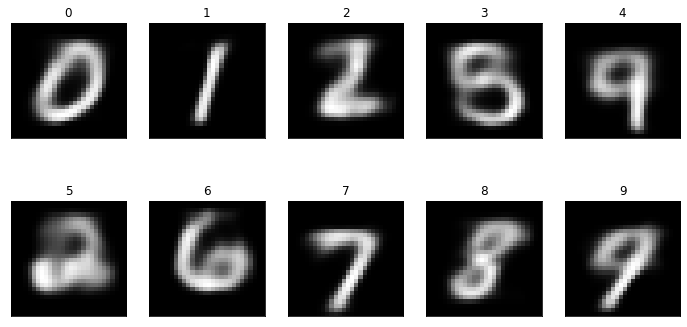

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x_hat = autoencoder.predict(x_test)
smp_idx = [3,2,1,18,4,8,11,0,61,9] # samples for 0,...,9 digits
plt.figure(figsize=(12,6))
for i, (img, y) in enumerate(zip(x_hat[smp_idx].reshape(10, 28, 28),
y_test[smp_idx])):
 plt.subplot(2,5,i+1)
 plt.imshow(img, cmap='gray')
 plt.xticks([])
 plt.yticks([])
 plt.title(y)
plt.show()


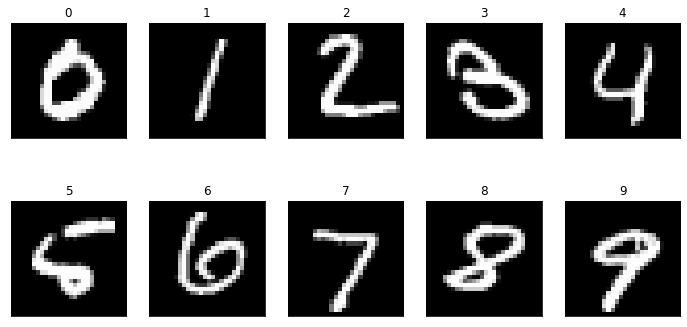

In [ ]:
plt.figure(figsize=(12,6))
for i, (img, y) in enumerate(zip(x_test[smp_idx].reshape(10, 28, 28),
y_test[smp_idx])):
 plt.subplot(2,5,i+1)
 plt.imshow(img, cmap='gray')
 plt.xticks([])
 plt.yticks([])
 plt.title(y)
plt.show()


313/313 [==============================] - 2s 5ms/step


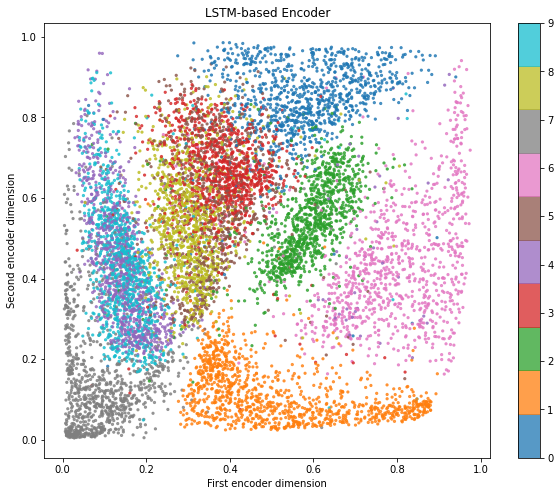

In [ ]:
y_ = list(map(int, y_test))
X_ = encoder.predict(x_test)
plt.figure(figsize=(10,8))
plt.title('LSTM-based Encoder')
plt.scatter(X_[:,0], X_[:,1], s=5.0, c=y_, alpha=0.75, cmap='tab10')
plt.xlabel('First encoder dimension')
plt.ylabel('Second encoder dimension')
plt.colorbar()
